<IPython.core.display.Javascript object>


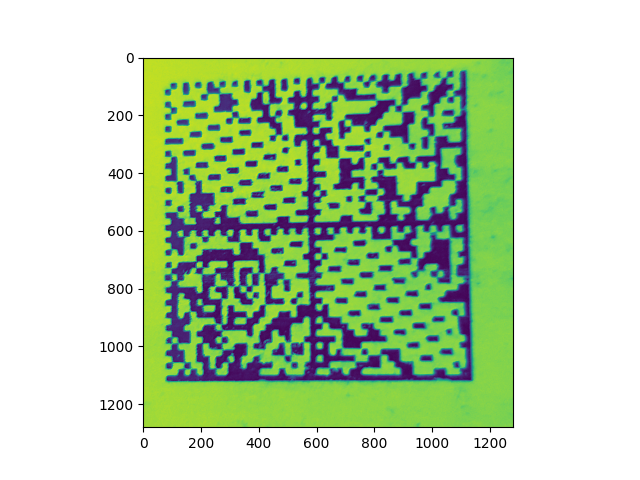

<IPython.core.display.Javascript object>


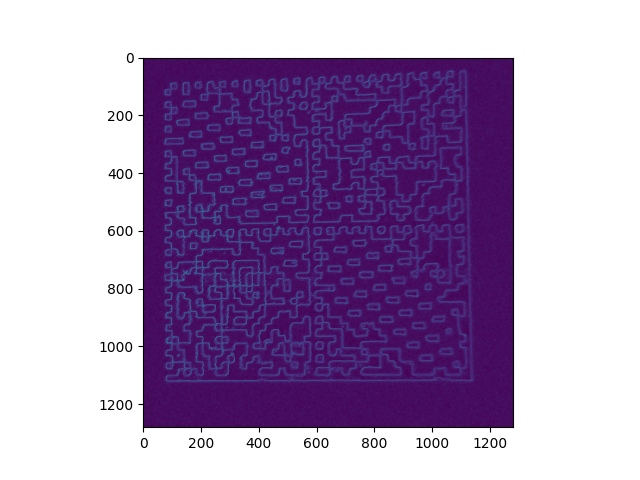

In [1]:
%matplotlib notebook

import matplotlib.pyplot
from PIL import Image
import numpy

image = Image.open("images/20200522_213922.jpg")
grey_image = image.convert("L")

numpy_image = numpy.asarray(grey_image)
# 800, 800+256*5
# 1500, 1500+256*5
numpy_barcode = numpy_image[800:2080, 1500:2780].astype(float)
edges = (numpy.pad(abs(numpy_barcode[1:] - numpy_barcode[:-1]),((0,1),(0,0))) +
         numpy.pad(abs(numpy_barcode[:,1:] - numpy_barcode[:,:-1]),
                   ((0,0),(0,1))))
edges -= sum(sum(edges)) / edges.size

figure = matplotlib.pyplot.figure()
axes = figure.add_subplot(1,1,1)

axes.imshow(numpy_barcode)

figure.show()


figure = matplotlib.pyplot.figure()
axes = figure.add_subplot(1,1,1)

axes.imshow(edges)

figure.show()

<IPython.core.display.Javascript object>


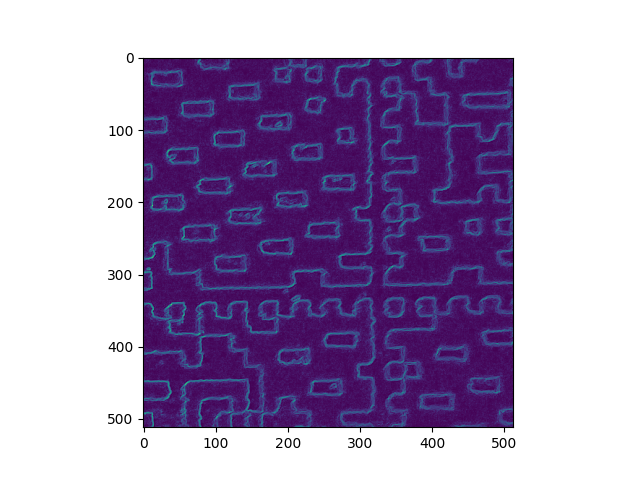

<IPython.core.display.Javascript object>


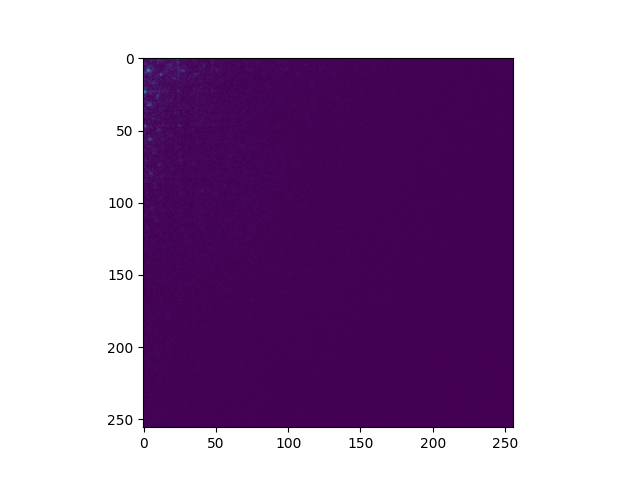

0 0 2261240.4377344223
0 23 1663717.1215991275
0 24 1658527.6819169233
1 0 1397489.2064072005
23 0 1365439.9804461338
1 24 1327185.4693963951
1 23 1326473.8193138184
3 9 1264544.6914200855
0 1 1212322.6222289926
4 9 1209475.0150045254


In [2]:
sub_edges = edges[256:768,256:768]
edges_f = numpy.fft.fft2(sub_edges)
grid = numpy.meshgrid(range(sub_edges.shape[0]), range(sub_edges.shape[1]))
x_grid, y_grid = grid
scale_factor = (x_grid**1.0+y_grid**1.0)**0.5
edges_f_scaled = edges_f * scale_factor


figure = matplotlib.pyplot.figure()
axes = figure.add_subplot(1,1,1)

axes.imshow(sub_edges)

figure.show()


figure = matplotlib.pyplot.figure()

axes = figure.add_subplot(1,1,1)
axes.imshow(abs(edges_f[:sub_edges.shape[0]//2,:sub_edges.shape[1]//2]))
#axes.set_xlim(0,50)
#axes.set_ylim(0,50)

figure.show()


x_step = y_step = 128

import scipy.signal
edges_f_copy = scipy.signal.convolve2d(abs(edges_f), numpy.ones((3,3)),
                                       'same', 'symm')
for i in range(10):
    max_loc = abs(edges_f_copy[:x_step//2,:y_step//2]).argmax()
    x_max_loc, y_max_loc = max_loc%(x_step//2), max_loc//(x_step//2)
    print(x_max_loc, y_max_loc, abs(edges_f_copy[y_max_loc, x_max_loc]))
    edges_f_copy[y_max_loc, x_max_loc] = 0

<IPython.core.display.Javascript object>


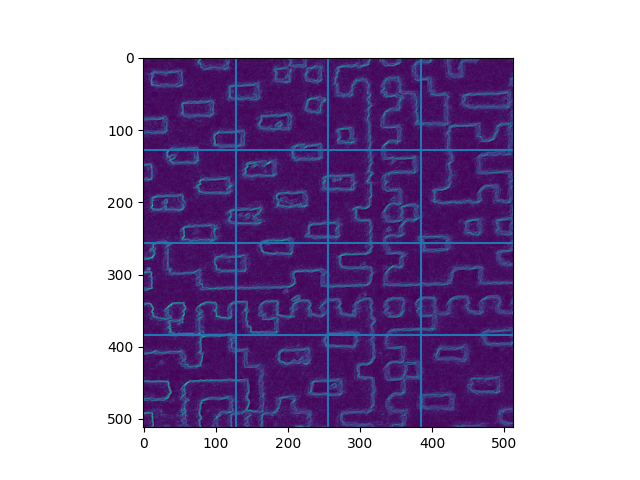

<IPython.core.display.Javascript object>


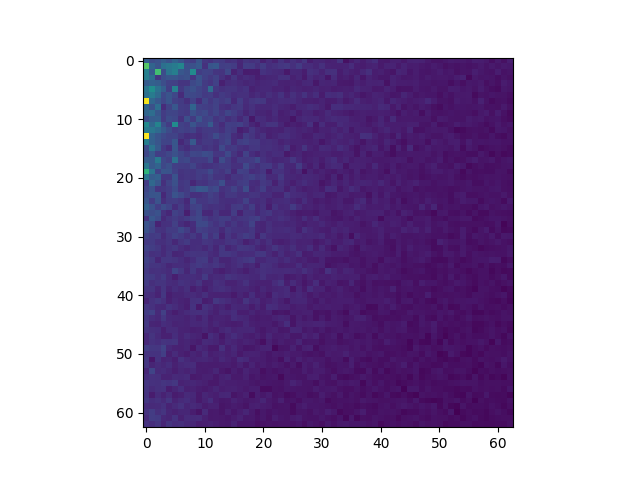

<IPython.core.display.Javascript object>


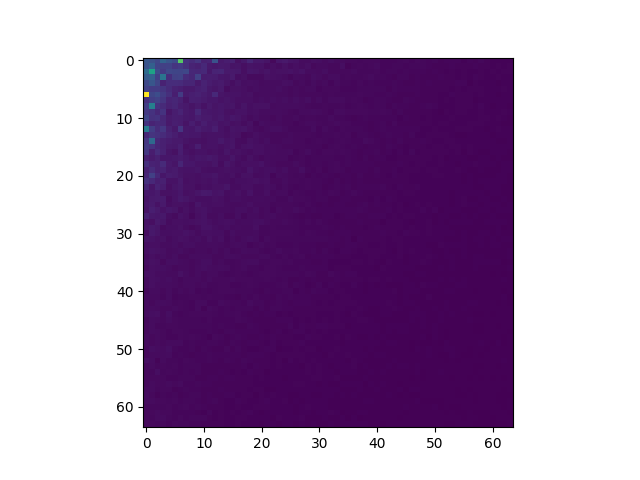

0 6
6 0


In [3]:
sub_edges = edges[256:768,256:768]
sub_edges -= sum(sum(sub_edges)) / sub_edges.size
edges_f = numpy.fft.fft2(sub_edges)
grid = numpy.meshgrid(range(sub_edges.shape[0]), range(sub_edges.shape[1]))
x_grid, y_grid = grid
scale_factor = (x_grid**1.0+y_grid**1.0)**0.5
edges_f_scaled = edges_f * scale_factor


figure = matplotlib.pyplot.figure()
axes = figure.add_subplot(1,1,1)

axes.imshow(sub_edges)
for i in range(128,512,128):
    axes.axvline(i)
    axes.axhline(i)

figure.show()


x_step = y_step = 128
sub_sub_edge_f = numpy.zeros((x_step,y_step))

for i in range(sub_edges.shape[0]//x_step):
    for j in range(sub_edges.shape[1]//y_step):
        sub_sub_edge_f += abs(numpy.fft.fft2(sub_edges[x_step*i:x_step*(i+1),
                                                       y_step*j:y_step*(j+1)]))


sub_grid = numpy.meshgrid(range(x_step), range(y_step))
x_grid, y_grid = sub_grid
scale_factor = (x_grid**1.0+y_grid**1.0)**0.5

        
figure = matplotlib.pyplot.figure()

axes = figure.add_subplot(1,1,1)
axes.imshow((sub_sub_edge_f*scale_factor)[1:x_step//2,1:y_step//2])
#axes.set_xlim(0,50)
#axes.set_ylim(0,50)

figure.show()

        
figure = matplotlib.pyplot.figure()

axes = figure.add_subplot(1,1,1)
axes.imshow(sub_sub_edge_f[:x_step//2,:y_step//2])
#axes.set_xlim(0,50)
#axes.set_ylim(0,50)

figure.show()

max_loc = sub_sub_edge_f[:x_step//2,:y_step//2].argmax()
x_max_loc, y_max_loc = max_loc%(x_step//2), max_loc//(x_step//2)
print(x_max_loc, y_max_loc)

second_sub_sub_edge_f = numpy.array(sub_sub_edge_f)
second_sub_sub_edge_f[y_max_loc, x_max_loc] = 0
max_loc = second_sub_sub_edge_f[:x_step//2,:y_step//2].argmax()
print(max_loc%(x_step//2), max_loc//(x_step//2))


<IPython.core.display.Javascript object>


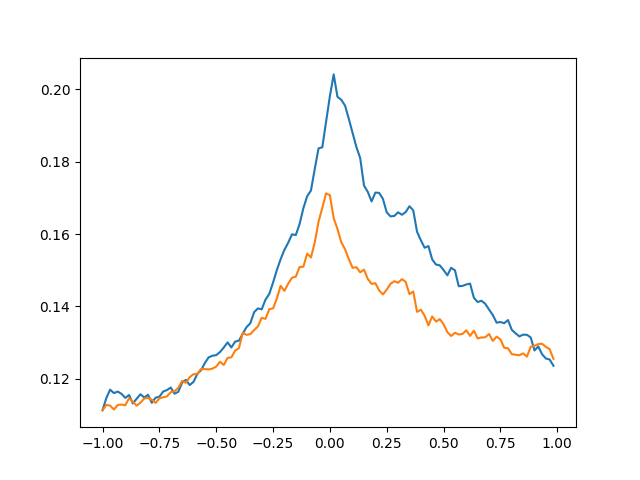

In [4]:
# Making the assumption this is square, if not...

x_size, y_size = edges_f.shape
abs_edges_f = abs(edges_f) / x_size / y_size

# Kill the noise near DC
abs_edges_f[0:4,0:4] *= 0
abs_edges_f[-3:,0:4] *= 0
abs_edges_f[0:4,-3:] *= 0
abs_edges_f[-3:,-3:] *= 0

slopes = [_/60 for _ in range(-60,60)]
y_results = [] # y = slope * x
x_results = [] # x = slope * y
result_45 = 0

# 45 special case
for i in range(x_size):
    for j in range(-1,2):
        result_45 += abs_edges_f[(i+j)%x_size,i]

for slope in slopes:
    y_result = 0
    x_result = 0
    weight = 0
    for i in range(x_size//2):
        for j in range(-1, 2):
            a, b = i, (round(slope*i)+j)%x_size
            if a > x_size // 2:
                a -= x_size
            if b > x_size // 2:
                b -= x_size
            weight_factor = (a**2 + b**2)**0
            y_result += abs_edges_f[a, b]**0.5 * weight_factor
            x_result += abs_edges_f[b, a]**0.5 * weight_factor
            weight += weight_factor
    x_result /= weight
    y_result /= weight
    y_results.append(y_result)
    x_results.append(x_result)


figure, axeses = matplotlib.pyplot.subplots(1,1)
axeses.plot(slopes, y_results)
axeses.plot(slopes, x_results)
figure.show()

<IPython.core.display.Javascript object>


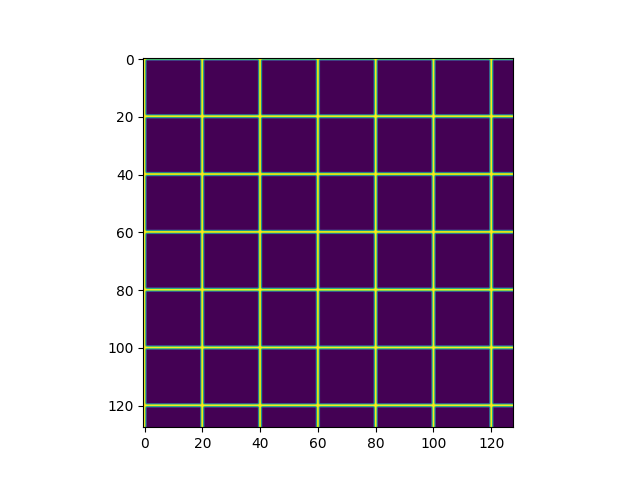

<IPython.core.display.Javascript object>


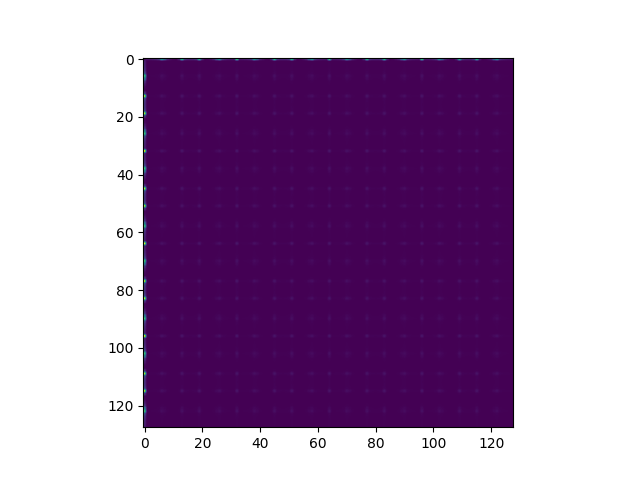

In [5]:
import math

z = numpy.zeros((128,128))

for i in range(128):
    for j in [0,20,40,60,80,100,120]:
        z[i,j] = 1
        z[j,i] = 1
        
z -= sum(sum(z))/128/128


figure = matplotlib.pyplot.figure()

axes = figure.add_subplot(1,1,1)
axes.imshow(z)
#axes.set_xlim(0,50)
#axes.set_ylim(0,50)

figure.show()


figure = matplotlib.pyplot.figure()

axes = figure.add_subplot(1,1,1)
axes.imshow(abs(numpy.fft.fft2(z)))
#axes.set_xlim(0,50)
#axes.set_ylim(0,50)

figure.show()